# 使用 PAI Python SDK 训练和部署 TensorFlow 模型

[TensorFlow](https://pytorch.org/) 是由Google开发的开源机器学习框架，它可以用于构建和训练各种类型的神经网络和机器学习模型。当前示例中，我们将使用PAI Python SDK，在PAI完成一个TensorFlow图片分类模型的训练和部署。主要流程包括：


1. 安装和配置SDK

安装PAI Python SDK，并完成SDK配置.

2. 准备数据集:

这里我们选择使用Fashion-MNIST数据集，将获取的数据集上传到OSS Bucket供训练作业使用。

3. 提交训练作业

按照PAI训练作业的范式，准备TensorFlow训练脚本，然后使用PAI Python SDK提供的Estimator API，将训练脚本提交到云上执行。

4. 部署模型

将以上训练作业输出的模型，部署到PAI-EAS，创建一个在线推理服务。



## Step1: 准备工作


我们需要首先安装PAI Python SDK以运行本示例。


In [ ]:
!python -m pip install --upgrade alipai


SDK 需要配置访问阿里云服务需要的 AccessKey，以及当前使用的工作空间和OSS Bucket。在 PAI SDK 安装之后，通过在 **命令行终端** 中执行以下命令，按照引导配置密钥，工作空间等信息。


```shell

# 以下命令，请在 命令行终端 中执行.

python -m pai.toolkit.config

```

我们可以通过以下代码验证当前的配置。

In [ ]:
import pai
from pai.session import get_default_session

print(pai.__version__)

sess = get_default_session()

assert sess.workspace_name is not None
print(sess.workspace_name)

## Step2: 准备训练数据

[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)是一个流行的视觉分类数据集，数据集中包含70,000张28x28像素的灰度图像，这些图像代表了10种不同类型的服装，包括衬衣、裤子、套装、鞋子等等。当前示例将使用`FashionMNIST`数据集训练一个服饰图片分类模型。

我们将首先下载数据到本地，然后再上传到OSS bucket中，供训练作业使用。


In [ ]:


# 下载训练数据集
!mkdir -p fashion-mnist/train/
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O fashion-mnist/train/images.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O fashion-mnist/train/labels.gz


# 下载测试数据集
!mkdir -p fashion-mnist/test/
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O fashion-mnist/test/images.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O fashion-mnist/test/labels.gz

!ls -lh fashion-mnist

In [ ]:
from pai.common.oss_utils import upload
from pai.session import get_default_session

sess = get_default_session()

train_data = upload(
    "fashion-mnist/train/",
    "example/data/fashion_mnist/train/",
    bucket=sess.oss_bucket,
)


test_data = upload(
    "fashion-mnist/test/",
    "example/data/fashion_mnist/test/",
    bucket=sess.oss_bucket,
)

print("train_data", train_data)
print("test_data", test_data)

在本地环境中，加载和验证下载的数据集。

In [ ]:
!python -m pip install pillow

import gzip
import os
import numpy as np
from PIL import Image
from IPython import display


def load_dataset(data_path):
    image_path = os.path.join(data_path, "images.gz")
    label_path = os.path.join(data_path, "labels.gz")

    with gzip.open(label_path, "rb") as f:
        labels = np.frombuffer(f.read(), dtype=np.int8, offset=8)

    with gzip.open(image_path, "rb") as f:
        images = np.frombuffer(f.read(), dtype=np.int8, offset=16).reshape(
            len(labels), 28, 28, 1
        )

    return images, labels


test_images, test_labels = load_dataset("./fashion-mnist/test/")
train_images, train_labels = load_dataset("./fashion-mnist/test/")

for arr in test_images[:5]:
    im = Image.fromarray(arr.reshape(28, 28), mode="L").resize((100, 100))
    display.display(im)

## Step2: 提交训练作业

通过SDK提供的`Estimator`API，用户可以将本地训练作业脚本提交到PAI执行。

### 2.1. 准备训练脚本

以下我们将基于TensorFlow提供的HighLevel Keras 构建一个2层的卷积神经网络训练模型，对于TensorFlow以及Keras API的详细介绍请参见TensorFlow的官方文档: [Basic classification: Classify images of clothing](https://www.tensorflow.org/tutorials/keras/classification)

训练脚本将被提交到PAI执行，在训练脚本的输入输出数据以及超参上需要遵循以下规范：

- 训练作业脚本通过读取本地文件的方式读取挂载到执行环境的数据

输入数据通过 `.fit` API 传递，对应的数据存储路径会被准备到训练作业容器中。执行的训练脚本可以通过环境变量`PAI_INPUT_{CHANNEL_NAME}` 获取输入数据的挂载路径，然后通过读取本地文件的方式拿到输入的数据。


- 训练脚本需要将输出的模型保存到指定路径

用户的训练代码必须在训练作业结束之后，将模型写出到 `PAI_OUTPUT_MODEL` 环境变量对应的路径下（默认为 `/ml/output/model/`）。

- 使用输入超参

训练服务预置了一些环境变量，支持用户引用获取超参，输入数据等，其中`PAI_USER_ARGS`是将用户指定的超参以命令行参数的形式拼接起来的字符串。用户的训练脚本可以通过Python argparse库解析输入的超参。


In [ ]:
!mkdir -p tf_train_src

In [ ]:
%%writefile tf_train_src/train.py

import tensorflow as tf
import argparse
import gzip
import os
import numpy as np

def load_dataset(data_path):
    image_path = os.path.join(data_path, "images.gz")
    label_path = os.path.join(data_path, "labels.gz")
    with gzip.open(label_path, "rb") as f:
        labels = np.frombuffer(
            f.read(), dtype=np.int8, offset=8
        )
    with gzip.open(image_path, "rb") as f:
        images = np.frombuffer(
            f.read(), dtype=np.int8, offset=16
        ).reshape(len(labels), 28, 28, 1)
    return images, labels


def train(batch_size, epochs, train_data, test_data):

    # Load dataset from input channel 'train' and 'test'.
    train_images, train_labels = load_dataset(train_data)
    test_images, test_labels = load_dataset(test_data)

    # model train
    num_classes = 10
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes),
        
    ])
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_labels), verbose=2)

    # save model

    model_path = os.environ.get("PAI_OUTPUT_MODEL")
    model.save(model_path)

    return model


def main():
    parser = argparse.ArgumentParser(description="PyTorch MNIST Example")
    parser.add_argument(
        "--batch_size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=14,
        metavar="N",
        help="number of epochs to train (default: 14)",
    )
    parser.add_argument(
        "--train_data",
        default=os.environ.get("PAI_INPUT_TRAIN"),
        help="Path to train data (default: /ml/input/data/train/)",
    )
    parser.add_argument(
        "--test_data",
        default=os.environ.get("PAI_INPUT_TEST"),
        help="Path to test data (default: /ml/input/data/test/)",
    )

    args = parser.parse_args()

    train(args.batch_size, args.epochs, args.train_data, args.test_data)


if __name__ == "__main__":
    main()

用户可以在本地测试对应的训练作业脚本，例如通过类似的以下命令

```shell

python tf_train_src/train.py --batch_size 32 --epochs 10 --train_data ./fashion-mnist/train --test_data ./fashion-mnist/test

```



### 2.3. 使用 Estimator 提交训练作业


`Estimator` 支持用户将本地的训练脚本，提交到 PAI ，使用云上的资源执行训练作业，他的主要参数包括以下:

- 用户通过 `entry_point` 和  `source_dir` 指定训练脚本:

`source_dir` 目录是本地执行脚本所在的目录，对应的目录会被打包上传到用户的OSS Bucket，然后准备到训练容器的 `/ml/usercode` 目录下。 `entry_point` 是训练作业的启动脚本，支持使用 Python 或是 Shell 文件。

- 通过 `image_uri` 指定作业的训练镜像:

在当前示例中，我们使用PAI提供的 `2.3` 版本的TensorFlow CPU镜像提交训练作业。


- 通过 `hyperparameters` 传递的作业使用的超参:

超参会通过命令行 arguments 的方式传递给到训练脚本。 例如以下示例中，对应的训练脚本的启动命令为:

```shell

python train.py --epochs 20 --batch-size 32

```

- 使用 `metric_definitions` 指定需要采集的Metric:

PAI 的训练服务从训练作业输出日志中，以正则的方式捕获用户指定的Metrics信息。用户可以通过作业详情页查看输出日志。

- 使用 `instance_type` 指定作业使用的机器实例类型:

对于提交训练作业的更加详细的介绍，请查看 [文档:提交训练作业](https://pai-sdk.oss-cn-shanghai.aliyuncs.com/pai/doc/latest/user-guide/estimator.html)

在通过 `.fit` API提交训练作业之后，控制台会打印训练作业的控制台详情链接，用户可以通过该链接到控制台查看作业的日志，采集的Metric，机器资源利用率等更多训练作业信息。

In [ ]:
from pai.estimator import Estimator
from pai.image import retrieve


# 获取PAI提供的TensorFlow 2.3的CPU镜像
image_uri = retrieve("TensorFlow", framework_version="2.3").image_uri
print(image_uri)

# 配置训练作业
est = Estimator(
    command="python train.py $PAI_USER_ARGS",
    source_dir="./tf_train_src/",
    image_uri=image_uri,
    instance_type="ecs.g6.xlarge",
    instance_count=1,
    hyperparameters={
        "batch_size": 32,
        "epochs": 20,
    },
    metric_definitions=[
        {
            "Name": "loss",
            "Regex": r".*loss: ([-+]?[0-9]*.?[0-9]+(?:[eE][-+]?[0-9]+)?).*",
        },
        {
            "Name": "accuracy",
            "Regex": r".*accuracy: ([-+]?[0-9]*.?[0-9]+(?:[eE][-+]?[0-9]+)?).*",
        },
        {
            "Name": "val_loss",
            "Regex": r".*val_loss: ([-+]?[0-9]*.?[0-9]+(?:[eE][-+]?[0-9]+)?).*",
        },
        {
            "Name": "val_accuracy",
            "Regex": r".*val_accuracy: ([-+]?[0-9]*.?[0-9]+(?:[eE][-+]?[0-9]+)?).*",
        },
    ],
    base_job_name="tf_tutorial_",
)

# 提交训练作业
est.fit(
    {
        "train": train_data,
        "test": test_data,
    }
)

print(est.model_data())

在训练结束之后，用户可以通过`est.model_data()` API拿到用户写出到`/ml/output/model`路径下的模型保存到OSS后的路径地址。

In [ ]:
print(est.model_data())

## Step3: 部署推理服务

以下我们将训练产出的模型部署到 PAI 创建在线推理服务，部署推理服务的主要流程包括：

- 通过 `InferenceSpec` 描述如何使用模型构建推理服务。

用户可以选择使用 Processor 模式，或是自定义镜像的模式进行模型部署。这里我们使用了 PAI 提供的预置 TensorFlow Processor部署一个在线服务。

- 通过 `Model.deploy` 方法，配置服务的使用资源，服务名称，等信息，创建推理服务。

- 通过 deploy 方法返回的 `Predictor`，可以向推理服务发送预测请求。

对于部署推理服务的详细介绍，可以见: [文档:部署推理服务](https://pai-sdk.oss-cn-shanghai.aliyuncs.com/pai/doc/latest/user-guide/model.html)

[Processor](https://help.aliyun.com/document_detail/111029.html) 是 PAI 对于推理服务程序包的抽象描述，他负责加载模型，启动模型推理服务。模型推理服务会暴露 API 支持用户进行调用。

对于 TensorFLow，PAI提供了预置的 [TensorFlow Processor](https://help.aliyun.com/document_detail/468737.html) ，用户可以方便得将获得的 [SavedModel](https://www.tensorflow.org/guide/saved_model) 格式的模型部署到 PAI，创建推理服务。


In [ ]:
from pai.model import Model, InferenceSpec
from pai.common.utils import random_str


m = Model(
    model_data=est.model_data(),
    # 这里使用了 2.3 版本的 TensorFlow Processor。
    # 一般情况下建议用户使用最新的TensorFlow Processor创建服务。
    inference_spec=InferenceSpec(processor="tensorflow_cpu_2.3"),
)

p = m.deploy(
    service_name="tutorial_tf_{}".format(random_str(6)),
    instance_type="ecs.c6.xlarge",
)

print(p.service_name)
print(p.service_status)


`Model.deploy` 返回的 `Predictor` 对象指向新创建的推理服务，可以通过 predictor 获取在线服务的状态，发送在线请求给到推理服务。

使用 TensorFlow Processor的在线服务，会通过一个API暴露推理服务的模型的签名信息，包含了模型的输入输出数据格式，[详情可见 TensorFlow Processor介绍](https://help.aliyun.com/document_detail/468737.html#section-w41-c2x-vsb)。

> 当前仅 TensorFlow Processor 拉起的在线服务支持获取模型签名信息。

通过 SDK 提供的 `predictor.inspect_model_signature` 获取相应的模型签名。

In [ ]:
import json


model_signauture_def = p.inspect_model_signature_def()

print(json.dumps(model_signauture_def, indent=4))

{
    "signature_name": "serving_default",
    "inputs": [
        {
            "name": "conv2d_input",
            "shape": [
                -1,
                28,
                28,
                1
            ],
            "type": "DT_FLOAT"
        }
    ],
    "outputs": [
        {
            "name": "dense_1",
            "shape": [
                -1,
                10
            ],
            "type": "DT_FLOAT"
        }
    ]
}


通过 `Predictor.predict` 方法，可以向推理服务发送预测请求，拿到模型推理之后的结果。

通过 `inspect_model_signature_def`，我们可以拿到模型的输入签名信息，然后可以使用对应的信息构建我们的请求数据。以上的模型只有一个Input，Name是 conv2d_input，输入数据格式是 (-1, 28, 28, 1)，分别为 (BatchSize, Height, Width, ChannelCount), 我们需要将数据reshpe成符合要求的格式，然后发送给到推理服务。

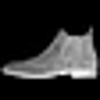

Ankle boot


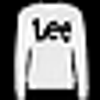

Pullover


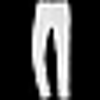

Trouser


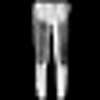

Trouser


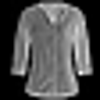

T-shirt/top


In [ ]:
from IPython import display
from PIL import Image
import numpy as np

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


for arr in test_images[:5]:

    res = p.predict(
        data={
            "conv2d_input": arr.reshape(1, 28, 28, 1),
        }
    )
    idx = np.argmax(res["dense_1"][0])
    display.display(Image.fromarray(arr.reshape(28, 28), mode="L").resize((100, 100)))
    print(class_names[idx])

在测试完成之后，删除相关的服务，释放资源。

In [ ]:
p.delete_service()